# Diabeties Prediction Models

In this notebook I  put together four diabeties detection algorithm, the first is a logistic regression, the second a decision tree, third a deep learning model and lastly a random forest model. The dataset can be found here (https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset)

## Dependencies  

In [156]:
# Data handling
import pandas as pd 
# Linear algebra
import numpy as np
# Plots
import matplotlib.pyplot as plt 
import seaborn as sns
# Statistics
from scipy import stats
# Data preprocessing
from sklearn import preprocessing, svm 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import torch
from sklearn.ensemble import RandomForestClassifier 
# Evaluation 
from sklearn import metrics 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from collections import Counter

## Bringing in the data

In [157]:
# Bringing the data into pandas so we can begin our analysis.

df = pd.read_csv('diabetes_prediction_dataset.csv')

In [158]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


As we can see there is this anonymized data that includes the 28 felids that represent some data about the transactions, an amount and a classification of fraud or not fraud. 

In [159]:
# To see the datatypes of our dataframe.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


## Visualization

The next stage is some data visualization, here I will go ahead and plot some of our data categories against our target variable which is diabetes. First the numerical features.

Text(0.5, 1.0, 'Age vs Diabetes')

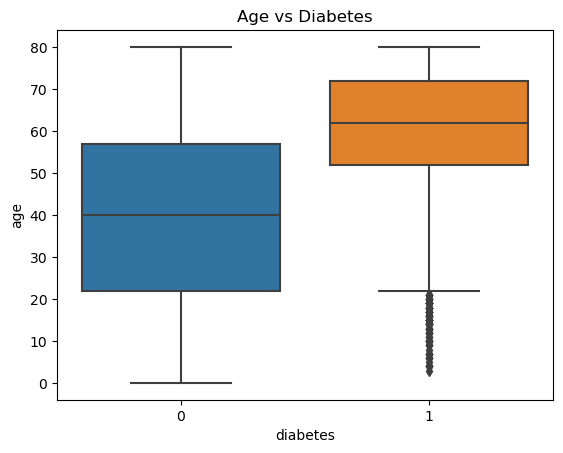

In [160]:
ax = sns.boxplot(data = df , x= 'diabetes', y = 'age')
plt.title('Age vs Diabetes')

Text(0.5, 1.0, 'Bmi vs Diabetes')

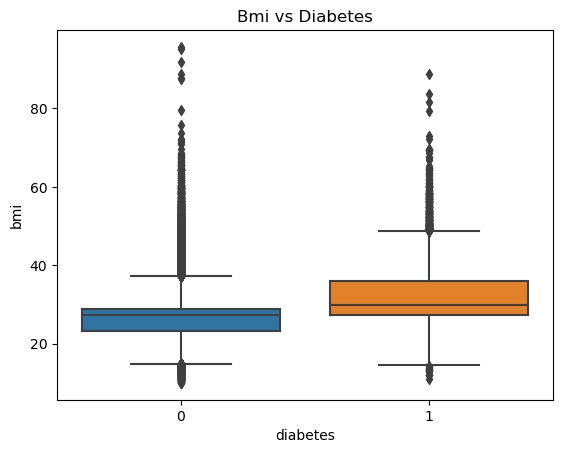

In [161]:
ax = sns.boxplot(data = df , x= 'diabetes', y = 'bmi')
plt.title('Bmi vs Diabetes')

Text(0.5, 1.0, 'HbA1c_level vs Diabetes')

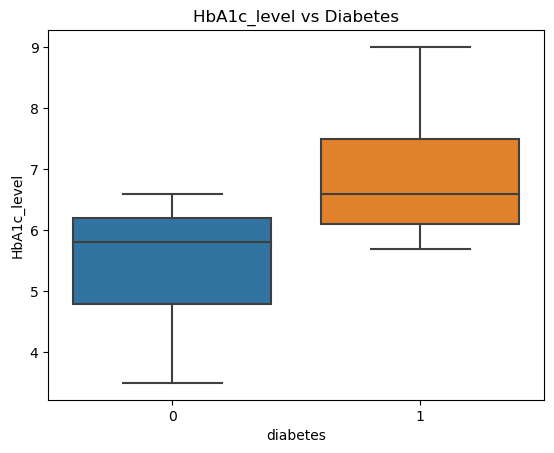

In [162]:
ax = sns.boxplot(data = df , x= 'diabetes', y = 'HbA1c_level')
plt.title('HbA1c_level vs Diabetes')

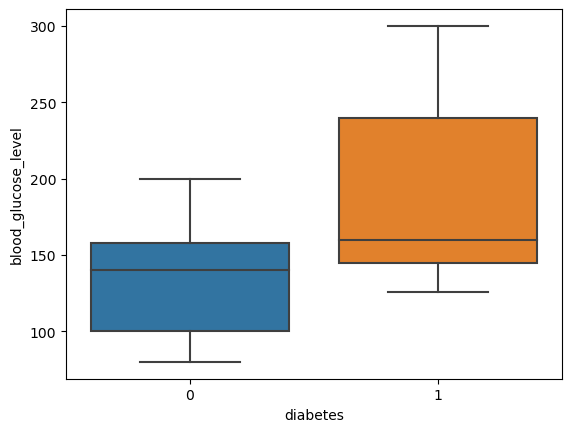

In [163]:
ax = sns.boxplot(data = df , x= 'diabetes', y = 'blood_glucose_level')

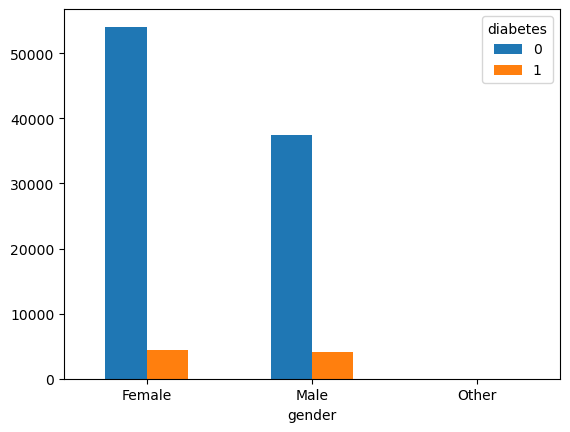

In [164]:
crosstb = pd.crosstab(df.gender, df.diabetes)
barplot = crosstb.plot.bar(rot=0)

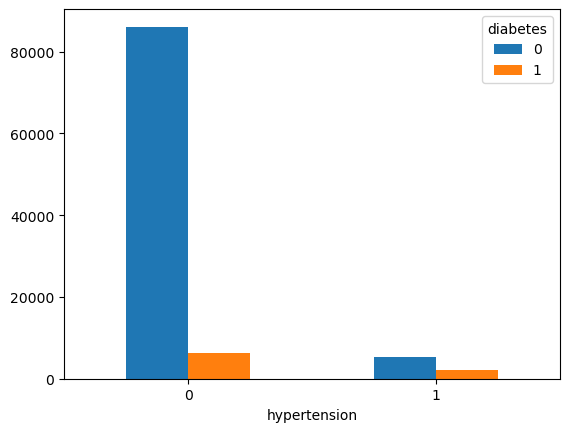

In [165]:
crosstb = pd.crosstab(df.hypertension, df.diabetes)
barplot = crosstb.plot.bar(rot=0)

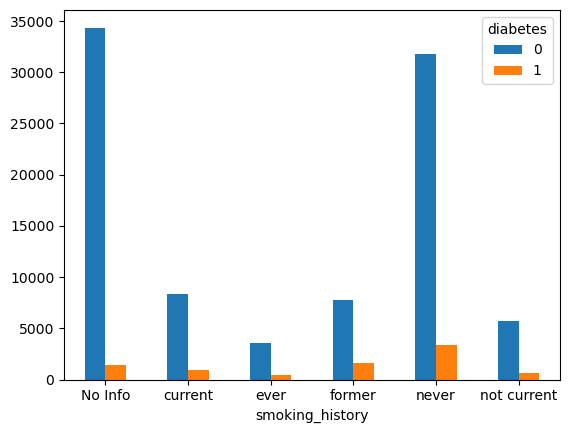

In [166]:
crosstb = pd.crosstab(df.smoking_history, df.diabetes)
barplot = crosstb.plot.bar(rot=0)

## Processing the data for analysis

As we can see it is mix of categorical data and numeric data, with a classification column at the end. The first process will be turning this data into numeric data where it has not already been transformed. In particular the smoking status and the gender catagories. Starting with the more complicated smoking category.

In [167]:
# The next thing that we need to do is transform the Smoking history column. First lets see what is in that column.

df.smoking_history.value_counts()

No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: smoking_history, dtype: int64

There are 6 Catagories of smoker here, including one where there is no information, but also the 'ever' category, which I would suspect is a typo and needs to be corrected to 'never'. we also need to combine the former and not current categories which we will do in a similar manor. 

In [168]:
df['smoking_history'] = df['smoking_history'].apply(lambda x: 'never' if x == 'ever' else x)
df['smoking_history'] = df['smoking_history'].apply(lambda x: 'former' if x == 'not current' else x)


As we can see in the next cell the ever category is no longer present. 

In [169]:
df.smoking_history.value_counts()

never      39099
No Info    35816
former     15799
current     9286
Name: smoking_history, dtype: int64

Now something has to be done about the 'No info' category. my current inclination is to assign it an interpolated value that would be the same as former smoker in this instance.

In [170]:
df['smoking_history'] = df['smoking_history'].apply(lambda x: 'former' if x == 'No Info' else x)


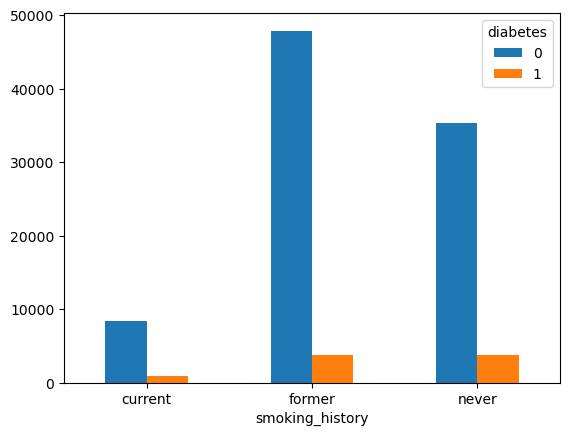

In [171]:
df.smoking_history.value_counts()
crosstb = pd.crosstab(df.smoking_history, df.diabetes)
barplot = crosstb.plot.bar(rot=0)

Now this information needs to be transformed into numerically represented categorical data, there are multiple ways that I could do this, the first would be to assign a value of 0.5 to previous smokers and no info, 1 to current smokers and 0 to never smoked. I will go with this approach because the other solution to have 'smoked in the past' and 'smoked currently' would have some coliniarity and may hurt the accuracy of the regression models. Notably though, assigning former to 0.5 is a non linear transformation, we don't know that the effect is 50% of the currently smoking effect, for that reason it will hurt non linear models. 

In [172]:
df['smoking_history'] = df['smoking_history'].apply(lambda x: 0 if x == 'never' else x)
df['smoking_history'] = df['smoking_history'].apply(lambda x: 0.5 if x == 'former' else x)
df['smoking_history'] = df['smoking_history'].apply(lambda x: 1 if x == 'current' else x)

The next column that I need to change to categorical is the 'Gender' category, as such I will be assigning '1' to female and '0' to male.




In [173]:
df.gender.value_counts()

Female    58552
Male      41430
Other        18
Name: gender, dtype: int64

As we can see below there are 18 candidates who fall into the other category, given that the size of the dataset is 100000, it is ok to remove them from out analysis, not something that I could do with the not insignificant 'No info' category for smoking history. This does show that there is need for more anaysis of likelyhood of diabeties in people who do ot fall under 'male' or 'female' but remains outside the scope of this project. 

In [174]:
df = df[df.gender != 'Other']
df['gender'] = df['gender'].apply(lambda x: 1 if x == 'Female' else 0)

df.gender.value_counts()

1    58552
0    41430
Name: gender, dtype: int64

In [175]:
# Separating the feature set from the target variable

feature_set = df.drop('diabetes', axis=1)
target_set = df['diabetes']

In [176]:
# To do our train test split of the data.

X_train, X_test, y_train, y_test = train_test_split(feature_set, target_set, test_size= 0.20, random_state= 42)


In [177]:
# This dictionary will be used later to label the confusion matrices

class_names = {0:'Diabetes', 1:'Not_Diabetes'}

## Logistic Regression

In [178]:
# Notice here how I have increased the maximum number of iterations from the usual 100, given the number of features and the size of the dataset more than the standard is needed

logistic_regression_model = LogisticRegression(max_iter=1000)

logistic_regression_model.fit(X_train, y_train.values.ravel())

LogisticRegression(max_iter=1000)

In [179]:
# Running our test data through the model

predictions = logistic_regression_model.predict(X_test)


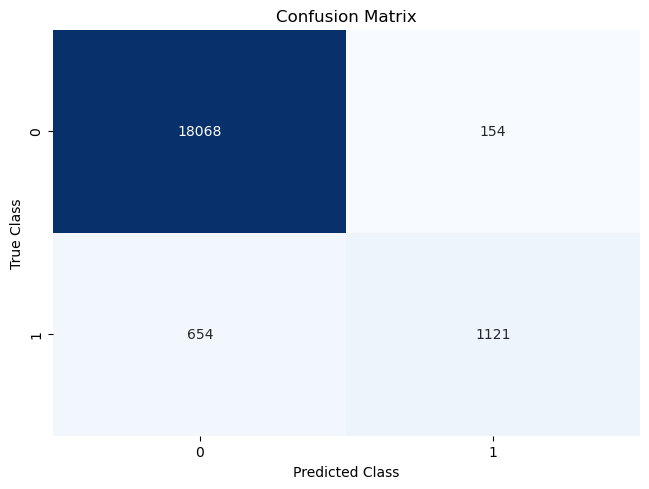

In [180]:
matrix = confusion_matrix(y_test, predictions)

dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)

sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues", fmt = 'g')
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

To evaluate the model above we are going to consider the precision and the recall. 

The precision is important because we want to know what our ratio of true positives are to total positives are. This tells use how often are we getting the wrong person. For fraud detection is is a measure of how much time the algorithm will waste by pursuing false positives. A number closer to one is better in this case. An algorithm that identifies everyone as fraudulent would catch every case of fraud but would be pointless. 

The recall is important because it tells us how many of the target category the model "missed". The ideal score is closer to 1. 


In [181]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     18222
           1       0.88      0.63      0.74      1775

    accuracy                           0.96     19997
   macro avg       0.92      0.81      0.86     19997
weighted avg       0.96      0.96      0.96     19997



## Decision Tree

In [182]:
# Calling the decision tree classifier from SK learn 

clf = DecisionTreeClassifier()

In [183]:
# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

In [184]:
#Predict the response for test dataset
y_pred = clf.predict(X_test)

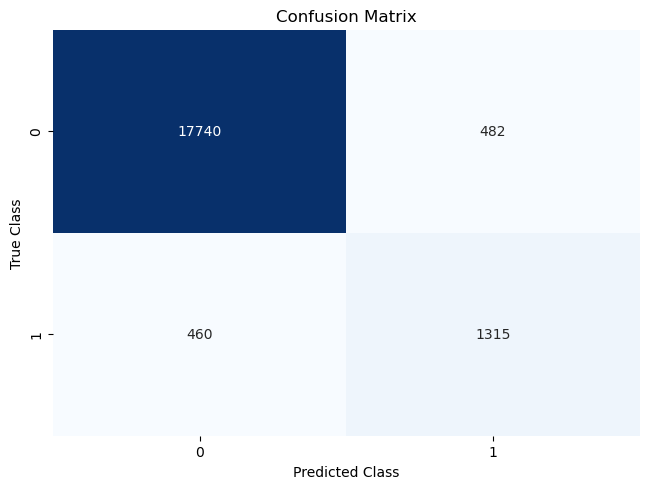

In [185]:
matrix = confusion_matrix(y_test, y_pred)

dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)

sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues", fmt = 'g')
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

In [186]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     18222
           1       0.73      0.74      0.74      1775

    accuracy                           0.95     19997
   macro avg       0.85      0.86      0.86     19997
weighted avg       0.95      0.95      0.95     19997



As we can see the decision tree outperforms the logistic regression on the same data, on both precision and recall.

## Deep learning

In [187]:
# The first thing that we need to do is to scale the data so we don't end up with gradient explosion issues. 


# Original dataset
x = feature_set.values
y = target_set.values
scaler = MinMaxScaler()
scaler.fit(x)
x = scaler.transform(x)
X_train1, X_test1, y_train1, y_test1 = train_test_split(x, y, test_size=0.2, random_state=42)

print('Sampled train dataset shape %s' % Counter(y_train1))
print('Sampled validation dataset shape %s' % Counter(y_test1))

Sampled train dataset shape Counter({0: 73260, 1: 6725})
Sampled validation dataset shape Counter({0: 18222, 1: 1775})


In [188]:
# time to bring it into pytorch and the torch dataloaders
batch_size = 64

numeber_of_cores = 7

training_dataset =  torch.utils.data.TensorDataset(torch.tensor(X_train1).float(), torch.tensor(y_train1).float())
test_dataset =      torch.utils.data.TensorDataset(torch.tensor(X_test1).float(), torch.tensor(y_test1).float())

train_dataloader = torch.utils.data.DataLoader(training_dataset,batch_size=batch_size, num_workers = numeber_of_cores)
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size, num_workers = numeber_of_cores)

In [189]:
# Creating the neural network class defining a two layer model that has ReLu layers between

class Classifier(torch.nn.Module):
    def __init__(self,n_input =10 , n_hidden = 15, n_output = 4, drop_prob = 0.5):
        super().__init__()
        # The first hidden layer
        self.extractor1 = torch.nn.Linear(n_input, n_hidden)
        # Second hidden layer
        self.extractor2 = torch.nn.Linear(n_hidden, n_hidden)
        # Third hidden layer
        self.extractor3 = torch.nn.Linear(n_hidden, n_hidden)
        # Relu non linear layer
        self.relu = torch.nn.ReLU()
        # A drop out for better learning
        self.dropout = torch.nn.Dropout(drop_prob)
        # The final layer that will pass out the classification
        self.classifier = torch.nn.Linear(n_hidden,n_output)
    # Forward pass of the data, taking it and   
    def forward(self, x_batch):
        x = self.relu(self.extractor1(x_batch))
        x = self.relu(self.extractor2(x))
        x = self.dropout(x)
        return self.classifier(x).squeeze()

In [190]:
def loss(model, loss_function, x_batch , y_batch, opt = None):
        # Using the loss function of choise to calculate the loss on each step
    loss = loss_function(model(x_batch),y_batch)
    # Just to make sure we arent going to throw and error if there isnt an actual optimiser to use.
    if opt is not None:
            loss.backward()
            opt.step()
            opt.zero_grad()
    return loss.item(), len(x_batch)

In [191]:
# Function to train the model using a loop over the epochs

def train(model, epochs, loss_function, opt, train_dl, test_dl):
    for epoch in range(epochs):
        # Making sure the model is in train mode
        model.train()
        # for each of the minibatches
        for x_batch, y_batch in train_dl:
            loss(model, loss_function,x_batch,y_batch,opt)
        # taking the model out of training mode and into testing mode so we can see wha the effect of the updated training is
        model.eval()
        with torch.no_grad():
            losses, nums = zip(*[loss(model, loss_function, xb, yb) for xb, yb in test_dl])
        test_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        # printing out the current loss, it also helps to know which epoch we are up to
        print(epoch, test_loss)
        

In [192]:
# Setting up the model parameters, first the number of input variables 

n_input = X_train1.shape[1]

# Setting the output so it predicts a single variable
n_output = 1

# settign the number of hidden layers
n_hidden = 15

model = Classifier(n_input=n_input,n_hidden=n_hidden,n_output=n_output,drop_prob=0.2)

lr = 0.001
    
pos_weight = torch.tensor([5])
opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
loss_func = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

n_epoch = 200



In [193]:
train(model,n_epoch,loss_func,opt,train_dataloader,test_dataloader)
model.eval()

0 0.8161503657010839
1 0.48768272757047343
2 0.3505916221532761
3 0.3284092657105973
4 0.3223773396902814
5 0.31886301253112237
6 0.3165709675863611
7 0.3144974295315745
8 0.31245266866009136
9 0.31329881561907097
10 0.31037397808675
11 0.30715051059836884
12 0.30773105427653347
13 0.30511193614176063
14 0.3063524163275437
15 0.30586399573972656
16 0.30541214540480804
17 0.30697907966667753
18 0.30571911334335705
19 0.3047097302969917
20 0.30687804144191977
21 0.3065081989997064
22 0.30822288170333934
23 0.30634003208477256
24 0.30620350134922947
25 0.3050960733508172
26 0.30511024172093715
27 0.3053915361145076
28 0.30449573078733533
29 0.30374872830830113
30 0.30559124854252795
31 0.3059604943898485
32 0.30632821144077393
33 0.30360184846928506
34 0.30412153921205054
35 0.3042183940444117
36 0.30671128825723587
37 0.30461902982527994
38 0.3043414295038629
39 0.30371459080540203
40 0.3033500038165238
41 0.305207092559188
42 0.3033061568192281
43 0.303542326374424
44 0.3023430766591717

Classifier(
  (extractor1): Linear(in_features=8, out_features=15, bias=True)
  (extractor2): Linear(in_features=15, out_features=15, bias=True)
  (extractor3): Linear(in_features=15, out_features=15, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (classifier): Linear(in_features=15, out_features=1, bias=True)
)

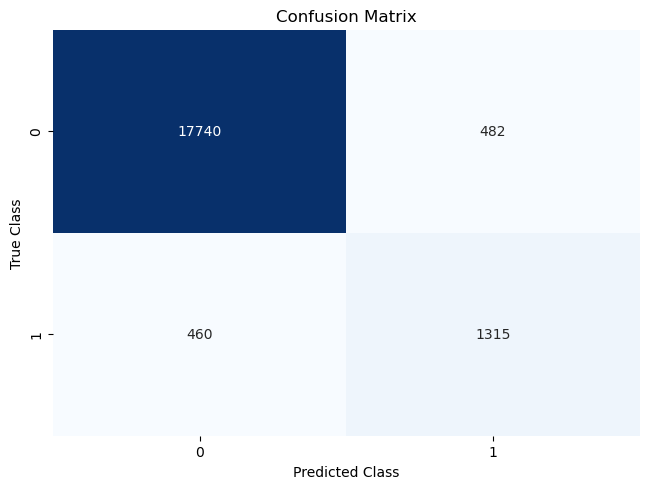

In [194]:
ypred = model(torch.tensor(X_test1).float()).detach().numpy()

ypred [ypred>=0.5] =1.0
ypred [ypred<0.5] =0.0

matrix = confusion_matrix(y_test, y_pred)

dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)

sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues", fmt = 'g')
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

In [195]:
print(metrics.classification_report(y_test1, ypred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     18222
           1       0.90      0.71      0.79      1775

    accuracy                           0.97     19997
   macro avg       0.93      0.85      0.89     19997
weighted avg       0.97      0.97      0.97     19997



As we can see here the deep learning model as performed significantly better than the logistic regression model and beats out the decision tree. The training time remains reasonable, unlike the decision tree module. It does help that it can be trained with 4 parallel treads which the decision tree code I wrote cannot. 

## Random forests

In [196]:
# calling the random forest

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [197]:
y_pred = rf.predict(X_test)

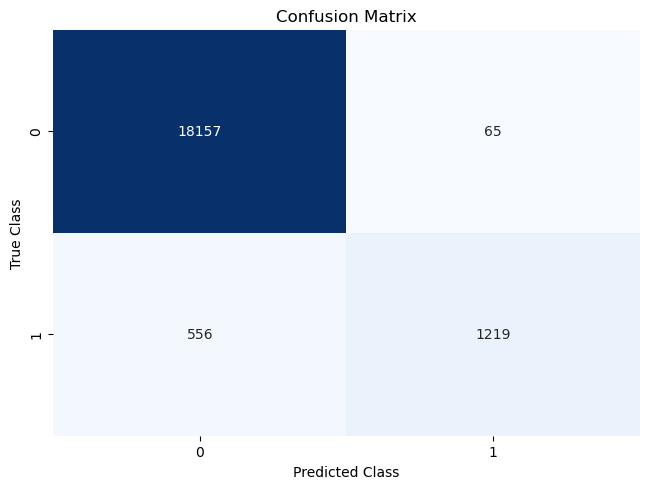

In [198]:
matrix = confusion_matrix(y_test, y_pred)

dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)

sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues", fmt = 'g')
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()